# Data
##### https://www.kaggle.com/noelmat/univariate-analysis-of-armed-robberies-in-boston/data

In [98]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
import math
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

In [40]:
dataset = pd.read_csv('dataset.csv')

In [41]:
dataset.shape

(106, 2)

In [42]:
dataset.head(5)

,Month,Robberies
0,01-01-1966,41
1,01-02-1966,39
2,01-03-1966,50
3,01-04-1966,40
4,01-05-1966,43


Performance Measure: RMSE
Test Strategy: walk-forward validation
1. 50% data will be held back to train the model
2. remaining 50% will be iterated and test the mode
3. for each in test dataset:</br>
a. train a model </br>
b. one-step prediction made and prediction stored for later evaluation</br>
c. actualobservation from the test dataset will be added to the training dataset for the next iteration</br>

# Baseline
# Persistence Model

In [24]:
robbery = robberies.tolist()
train_size = int(len(robbery) * 0.5)
train, test = robbery[:train_size], robbery[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Predicted=98.000, Expected=125.000
Predicted=125.000, Expected=155.000
Predicted=155.000, Expected=190.000
Predicted=190.000, Expected=236.000
Predicted=236.000, Expected=189.000
Predicted=189.000, Expected=174.000
Predicted=174.000, Expected=178.000
Predicted=178.000, Expected=136.000
Predicted=136.000, Expected=161.000
Predicted=161.000, Expected=171.000
Predicted=171.000, Expected=149.000
Predicted=149.000, Expected=184.000
Predicted=184.000, Expected=155.000
Predicted=155.000, Expected=276.000
Predicted=276.000, Expected=224.000
Predicted=224.000, Expected=213.000
Predicted=213.000, Expected=279.000
Predicted=279.000, Expected=268.000
Predicted=268.000, Expected=287.000
Predicted=287.000, Expected=238.000
Predicted=238.000, Expected=213.000
Predicted=213.000, Expected=257.000
Predicted=257.000, Expected=293.000
Predicted=293.000, Expected=212.000
Predicted=212.000, Expected=246.000
Predicted=246.000, Expected=353.000
Predicted=353.000, Expected=339.000
Predicted=339.000, Expected=3

This means that on average, the model was
wrong by about 51 robberies for each prediction made.

# Data Analysis

### summary statistics
The mean is about 173, which we might consider our level in this series.</br>
The standard deviation (average spread from the mean) is relatively large at 112 robberies.</br>
The percentiles along with the standard deviation do suggest a large spread to the data.

In [25]:
#summary statistics
robberies.describe()

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64

### Line plot

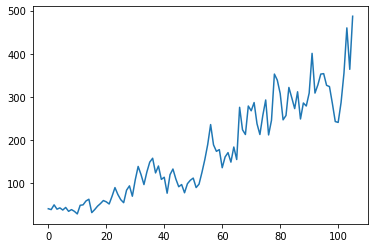

In [27]:
robberies.plot()
plt.show()

There is an increasing trend of robberies over time.</br>
There do not appear to be any obvious outliers.</br>
There are relatively large 
fluctuations from year to year, up and down.</br>
The fluctuations at later years appear larger than fluctuations at earlier years.</br>
The trend means the dataset is almost certainly non-stationary and the apparent chang in fluctuation may also contribute.

## density plot

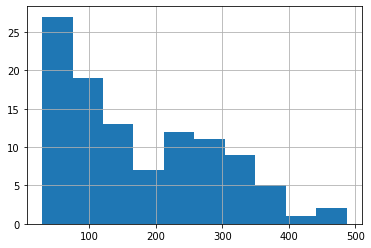

In [28]:
robberies.hist()
plt.show()

The distribution is not Gaussian.</br>
The distribution is left shifted and may be exponential or a double Gaussian.

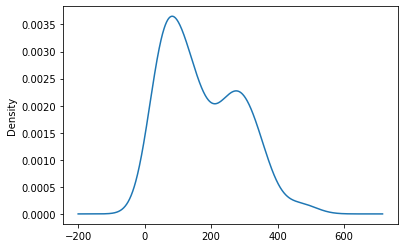

In [29]:
robberies.plot(kind = 'kde')
plt.show()

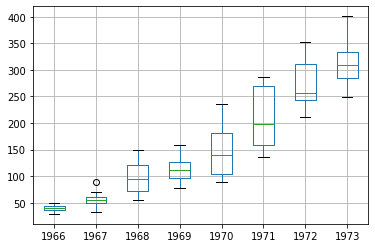

In [49]:
series = pd.read_csv('dataset (1).csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1966':'1973'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

The median values for each year (red line) show a trend that may not be linear.</br>
The spread, or middle 50% of the data (blue boxes), dier, but perhaps not consistently
over time.</br>
The earlier years, perhaps first 2, are quite different from the rest of the dataset.

# ARIMA
Make series stationary</br>
differencing: obs(t) - obs(t-1)</br>
stationary test


In [54]:
def difference(dataset):
    diff = []
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

In [55]:
stationary = difference(robberies)
stationary.index = series.index[1:]

In [58]:
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


The results show that the test statistic value -3.980946 is smaller than the critical value at 5% of -2.893. So, we can reject null hypothesis. Rejecting the null hypothesis means that
the process has no unit root, and in turn that the 1-lag differenced time series is stationary or
does not have time-dependent structure.</br>
This suggests that at least one level of differencing is required. The d parameter in our
ARIMA model should at least be a value of 1.

The next step is to select the lag values for
the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

The ACF shows a significant lag for 10-11 months.</br>The PACF shows a significant lag for perhaps 2 months.
</br>Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of
AR and MA.</br>
A good starting point for the p and q values are 11 and 2.

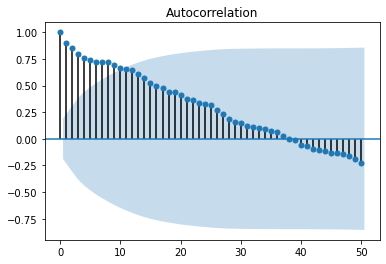

In [63]:
plot_acf(robberies, lags=50)
plt.show()

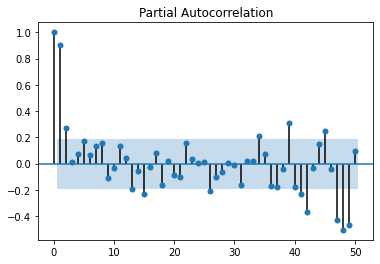

In [66]:
plot_pacf(robberies, lags=50)
plt.show()

In [72]:
X = robberies.tolist()
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Predicted=102.710, Expected=125.000
Predicted=118.868, Expected=155.000
Predicted=141.099, Expected=190.000
Predicted=176.593, Expected=236.000
Predicted=233.418, Expected=189.000
Predicted=186.905, Expected=174.000
Predicted=184.846, Expected=178.000
Predicted=183.763, Expected=136.000
Predicted=146.180, Expected=161.000
Predicted=171.279, Expected=171.000
Predicted=170.196, Expected=149.000
Predicted=154.425, Expected=184.000
Predicted=185.708, Expected=155.000
Predicted=157.284, Expected=276.000
Predicted=245.280, Expected=224.000
Predicted=222.242, Expected=213.000
Predicted=219.698, Expected=279.000
Predicted=261.506, Expected=268.000
Predicted=264.287, Expected=287.000
Predicted=282.759, Expected=238.000
Predicted=255.843, Expected=213.000
Predicted=235.189, Expected=257.000
Predicted=257.622, Expected=293.000
Predicted=280.345, Expected=212.000
Predicted=235.564, Expected=246.000
Predicted=255.342, Expected=353.000
Predicted=318.613, Expected=339.000
Predicted=310.335, Expected=

Grid hyperparameter Arima


In [86]:
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(np.array(robberies), p_values, d_values, q_values)

# Running this will give p,d,q as 0, 1, 2 as best suitable parameters

Residual Errors
The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case
that perhaps a power-based transform of the raw data before modeling might be useful.

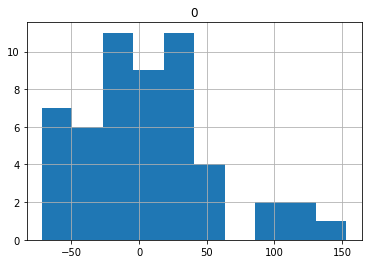

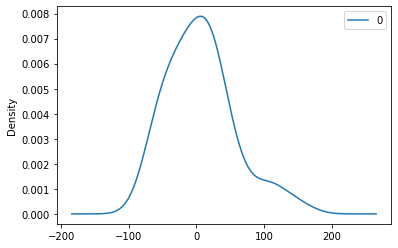

In [90]:
X = robberies.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
residuals.hist()
plt.show()
residuals.plot(kind='kde')
plt.show()

ACF and PACF plots of the residual errors from ARIMA</br>
The results suggest that what little autocorrelation is present in the time series has been
captured by the model.

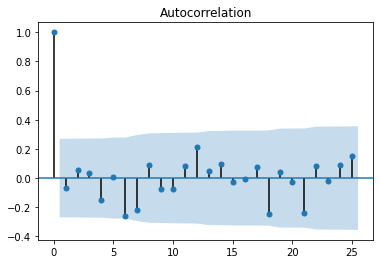

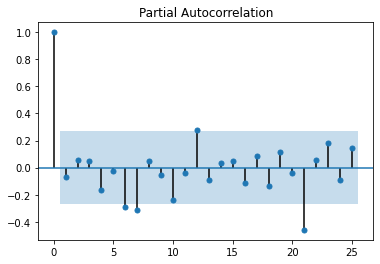

In [91]:
plot_acf(residuals, lags=25)
plt.show()
plot_pacf(residuals, lags=25)
plt.show()

# box-cox transformation

In [93]:
X = robberies.values
transformed, lam = boxcox(X)

Lambda: 0.260060


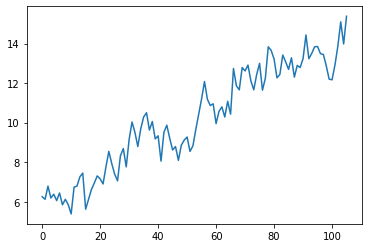

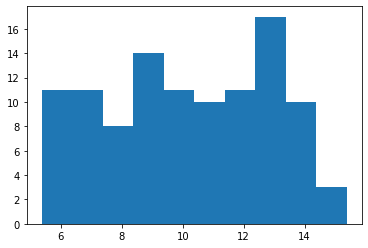

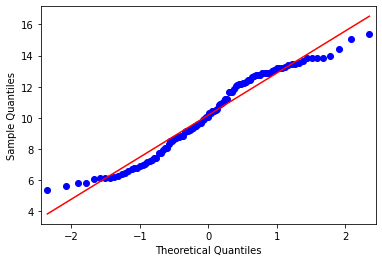

In [96]:
print('Lambda: %f' % lam)
# line plot
plt.plot(transformed)
plt.show()
# histogram
plt.hist(transformed)
plt.show()
# q-q plot
qqplot(transformed, line='r')
plt.show()

how the
distribution of values compared to an idealized Gaussian distribution</br>
The large 
fluctuations have been removed from the line plot of the time series.</br>
The histogram shows a 
atter or more uniform (well behaved) distribution of values.</br>
The Q-Q plot is reasonable, but still not a perfect fitt for a Gaussian distribution.

# ARIMA with box-cox transformation

In [100]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

X = robberies.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=104.062, Expected=125.000
>Predicted=119.209, Expected=155.000
>Predicted=138.905, Expected=190.000
>Predicted=166.139, Expected=236.000
>Predicted=205.831, Expected=189.000
>Predicted=183.612, Expected=174.000
>Predicted=184.410, Expected=178.000
>Predicted=186.637, Expected=136.000
>Predicted=154.261, Expected=161.000
>Predicted=175.660, Expected=171.000
>Predicted=174.168, Expected=149.000
>Predicted=159.916, Expected=184.000
>Predicted=187.302, Expected=155.000
>Predicted=161.653, Expected=276.000
>Predicted=244.354, Expected=224.000
>Predicted=212.416, Expected=213.000
>Predicted=221.180, Expected=279.000
>Predicted=262.629, Expected=268.000
>Predicted=260.125, Expected=287.000
>Predicted=283.321, Expected=238.000
>Predicted=255.089, Expected=213.000
>Predicted=241.698, Expected=257.000
>Predicted=267.302, Expected=293.000
>Predicted=286.367, Expected=212.000
>Predicted=237.879, Expected=246.000
>Predicted=265.181, Expected=353.000
>Predicted=323.319, Expected=339.000
>

The final RMSE of the model on the transformed data was
49.443. This is a smaller error than the ARIMA model on untransformed data, but only slightly,
and it may or may not be statistically dierent.

# final model
box-cox transformation with arima

# Reference

Introduction to Time Series Forecasting with Python: How to Prepare Data and Develop Models to Predict the Future by Jason Brownlee